In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def f(x):
    return 3*x**2 - 4*x + 5

In [17]:
f(3.0)

20.0

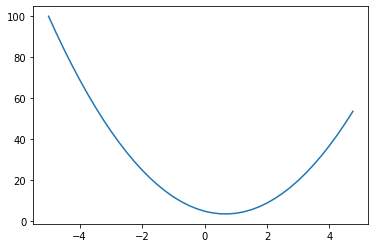

In [18]:
xs = np.arange(-5, 5, 0.25)
xs
ys = f(xs)
ys
plt.plot(xs, ys)

In [20]:
h = 0.001
x = 3.0
(f(x + h) - f(x)) / h

14.00300000000243

In [22]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [24]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c


print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [35]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out
    
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c